<h1><center> Задание 4</center></h1>

# 1
<p>
Посчитаем необходимую скорость поступления страховых выплат. $X_t = y_0 + ct - \sum\limits_{j = 0}^{N_t} \eta_j,~~~ \eta_j \tilde{} U[100; 200], N_t - пуассоновский ~ с ~ интенсивностью ~ 1$ <br>
$EX_t = y_0 + ct - 150 \cdot t\\$ <br>
Т.к. $\forall t \ge 0 : EX_t > 0$, то $c \ge 150$
</p>
<p>
Теперь найдем вероятность разорения.
$g(v) = Ee^{v\eta_1} - 1 - cv = \frac{e^{200v} - e^{100v}}{100v} - cv - 1 \Rightarrow 
c = \frac{e^{200v} - e^{100v} - 100v}{100v^2}$ <br>
По теореме $\exists! ~ v_0 > 0 : g(v_0) = 0$ <br>
При этом вероятность разорения $P(\tau < +\infty) \le e^{-v_0y_0}.$ 
Итак: <br>
$e^{-v_0y_0} = 0.01 \Rightarrow v_0 = \frac{\ln 100}{y_0}$ <br>
Исходя из этого найдем необходимую минимальную скорость поступления взносов: <br>
$с = \frac{e^{200v_0} - e^{100v_0} - 100v_0}{100v_0^2} = \frac{y_0^2 100^\frac{200}{y_0} - y_0^2 100^\frac{100}{y_0} - y_0 100 \ln 100}{100 \ln^2 100}$ <br>
Аналогично находятся скорости поступления взносов для других вероятностей.
Если взять начальный капитал $y_0$ равным, к примеру, максимальному размеру одной выплаты (т.е. $y_0 = 200$), получим: <br>
$c_{0.01} = \frac{100 (90 - \ln 10)}{\ln^2 10} \approx 1654\\
c_{0.05} \approx 625 \\
c_{0.1} \approx 429 $


# 2
<p>
Можно минимизировать такую функцию: $~ f(y) = y ^ 2 + c^2(y) = y^2 + \frac{y^2 \alpha^\frac{200}{y} - y^2 \alpha^\frac{100}{y} - y 100 \ln \alpha}{100 \ln^2 \alpha}$ в среднем квадратичном при фиксированном $\alpha$<br>
Здесь $\alpha = \frac{1}{p}, p - \text{требуемая максимальная вероятность разорения}$

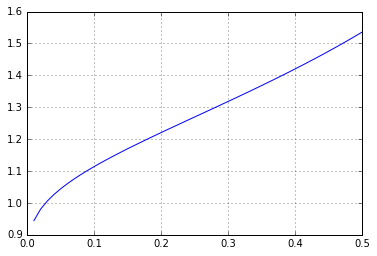

In [1]:
from scipy.optimize import minimize, leastsq
from math import log, exp
import matplotlib.pyplot as plt
%matplotlib inline

def c(y, p):
    v = log (1.0 / p) / y
    return (exp(200 * v) - exp(100 * v) - 100 * v) / 100.0 / v ** 2

def find_parameters (p):
    res = []
    for a in p:
        def f(y):
            return y ** 2 + c(y,a) ** 2
        res.append(leastsq(f, [20])[0][0])
    return res

p = [0.01 * i for i in range(1, 51)]
y = find_parameters(p)
ratio = [c(u, v) / u for (u,v) in zip(y,p)]
plt.grid()
plt.plot(p, ratio)

Как видно, можно аппроксимировать требуемое отношение для $0.02 \le p \le 0.5$

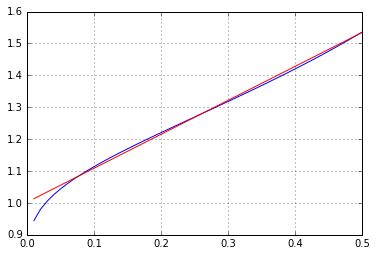

In [2]:
a = (ratio[39] - ratio[3]) / 0.37
b = ratio[25] - a * p[25]
plt.grid()
plt.plot(p, ratio, 'b')
plt.plot(p, [(a * q + b) for q in p], 'r')

Для первого приближения получилось достаточно неплохо.

# 3
<p>
Для моделирования процесса просто сгенерируем выборку используя найденные для конкретного $\alpha$ параметры $y_0$ и $c$

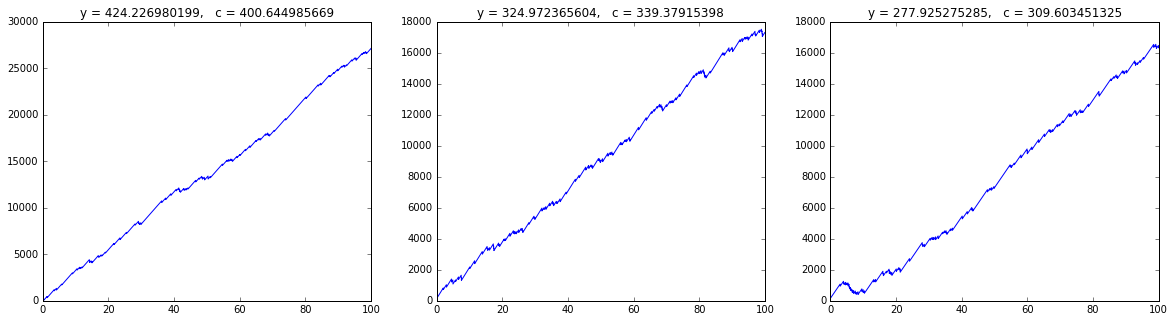

In [3]:
import numpy as np
from numpy.random import exponential, uniform, chisquare

def process(y, c, time, random_variable_function, *params):
    eta = []
    n = len(time)
    T = 0
    X = []
    for i in range(0, n):
        while time[i] > T:
            T += exponential(1,1)[0]
            eta.append(random_variable_function(*params,1)[0])
        X.append(y + c * time[i] - sum(eta))
        if X[i] < 0:
            break
    return X

p = [0.01, 0.05, 0.1]
y = find_parameters(p)
k = [c(u,v) for (u,v) in zip(y,p)]

plt.figure(figsize = (20,5))
time = np.linspace(0,100, 10000)

for i in range(len(y)):
    plt.subplot(1, len(y), i + 1)
    X = process(y[i], k[i], time, uniform, 100,200)
    plt.plot(time[:len(X)], X)
    plt.title('y = ' + str(y[i]) + ',   c = ' + str(k[i]))

В среднем как раз получается, что разорение в каждом из трех случаев происходит как раз примерно с нужной вероятностью.
По-хорошему, чтоб оценить вероятность разорения в каждом из случаев, надо сгенерировать все эти процессы раз этак по 300 хотя бы, но это долго

# 4
После генерации n-го количества процессов, я убедился, что в большинстве случаев процесс либо вырождается почти сразу $(\tau \le 1)$, либо не вырождается. <br>
Тогда можно за момент изменения $c$ взять $T \in [1;10]$. Например T = 5. При этом правило, по которому скорость поступления взносов можно уменьшить, можно определить пользуясь тем, что $X_t$ - процесс с независимыми приращениями. <br> 
Исходя из этого можно сказать, что у нас просто имеется новый подобный процесс, с той лишь разницей, что начальное значение у него - это не $y_0$, подобраное оптимально, а значение процесса в точке T.
При этом, т.к. начальное значение скорости поступления взносов было оптимальным в квадратичном смысле, значение интенсивности взносов в новой точке будет меньше (мы не разорились $\Rightarrow$ капитал вырос $\Rightarrow$ цена взносов уменьшилась)


y = 424.226980199, c = 400.644985669
y_new = 1505.77925243, c_new = 192.349212721

y = 324.972365604, c = 339.37915398
y_new = 1148.31874528, c_new = 185.192084456

y = 277.925275285, c = 309.603451325
y_new = 1167.1596161, c_new = 175.661013161



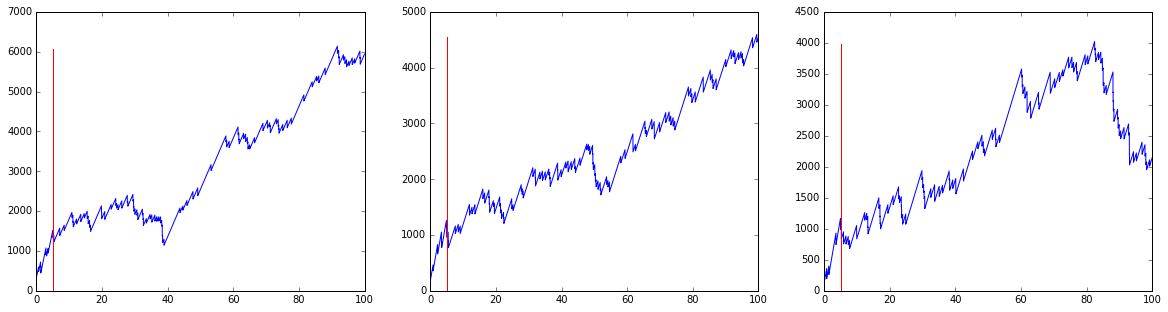

In [4]:
def print_graphs(disribution, *params):
    plt.figure(figsize = (20,5))
    y_new = []
    k_new = []
    for i in range(len(y)):
        plt.subplot(1, len(y), i + 1)
        X = process(y[i], k[i], time[:500], uniform, 100, 200)
        plt.plot(time[:len(X)], X)
        y_new.append(X[len(X) - 1])
        k_new.append(c(X[len(X) - 1], p[i]))
        print ('y = ' + str(y[i]) + ', c = ' + str(k[i]))
        if len(X) == 500:
            X = process(y_new[i], k_new[i], [time[i] - time[500] for i in range(500, 10000)], disribution, *params)
            plt.plot(time[500:500 + len(X)], X, 'b')
            plt.plot([time[500]] * 100, [max(X) / 100 * i for i in range(100)], 'r')
            print ('y_new = ' + str(y_new[i]) + ', c_new = ' + str(k_new[i]))
        print()
print_graphs(uniform, 100, 200)

Итак, как мы видим, скорость поступления взносов уменьшается раза в полтора, что является весьма существенным изменением.

 # 5

y = 424.226980199, c = 400.644985669
y_new = 1766.72729905, c_new = 185.158124545

y = 324.972365604, c = 339.37915398
y_new = 1250.87358949, c_new = 181.911143258

y = 277.925275285, c = 309.603451325



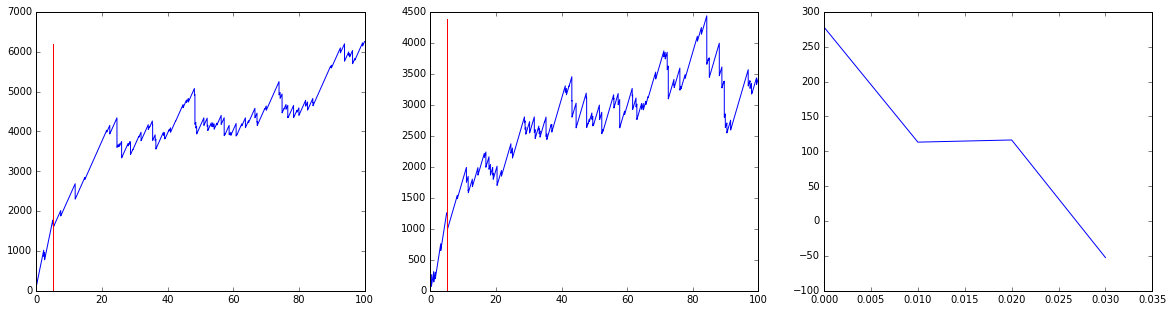

In [5]:
print_graphs(exponential, 150)

y = 424.226980199, c = 400.644985669
y_new = 1868.44285284, c_new = 182.973224944

y = 324.972365604, c = 339.37915398
y_new = 972.933431319, c_new = 192.688256825

y = 277.925275285, c = 309.603451325
y_new = 1104.88502777, c_new = 177.279170416



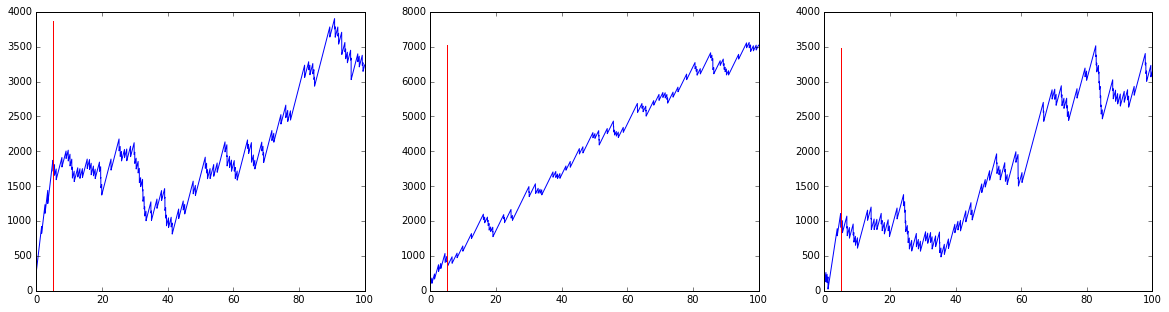

In [6]:
print_graphs(chisquare, 150)

Здесь были рассмотрены графики для следующих распределений: $exp(150), ~ \chi_{150}^2$

Анализ проведу только для экспоненциального распределения. <br>
$EX_t = y_0 + ct - \frac{1}{150} \cdot t\\$ <br>
Т.к. $\forall t \ge 0 : EX_t > 0$, то $c \ge \frac{1}{150}$
</p>
<p>
Теперь найдем вероятность разорения.
$g(v) = Ee^{v\eta_1} - 1 - cv = \frac{\lambda e^{(v - \lambda)x}}{v - \lambda} \Big |_0^{\infty} - cv - 1 = \big[g(v) = 0 \Rightarrow v < 150 \big] = \frac{\lambda}{\lambda - v} - cv - 1\Rightarrow 
c = \frac{1}{\lambda - v} = \frac{1}{150 - v}$ <br>
$c = \frac{y_0}{150y_0 + \ln p} I\big\{\frac{-\ln p}{y_0} < 150\big\}$